<a href="https://colab.research.google.com/github/MarijaGijic/mri-streamlit-app/blob/master/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import imageio
import cv2
from matplotlib.widgets import RectangleSelector
from matplotlib.patches import Rectangle


# Ucitavanje slika
Funkcija *load_images* ucitava slike i vraca recnik u kom su ucitane slike za svakog pojedinacnog pacijenta (key - patient_id, value - images)


In [2]:
def load_images(images_path, image_extensions):
  image_files = [f for f in os.listdir(images_path) if f.endswith(tuple(image_extensions))]
  patient_images = defaultdict(list)

  for image_file in image_files:
    img = Image.open(os.path.join(images_path, image_file))
    img_array = np.array(img)

    parts = image_file.split('_')
    patient_id = parts[2]

    patient_images[patient_id].append(img_array)

  return dict(patient_images)


def get_patient_images(patient_images, patient_id):
  return patient_images.get(patient_id, [])



In [3]:
images_path = '/content/drive/MyDrive/Images'
image_extensions = ['.jpg', '.png', '.gif', '.jpeg']

patient_images = load_images(images_path, image_extensions)

# Primer ucitavanja slika
Parametar *patient_id* jer podesiv i na taj nacin moze da se pristupi slikama svakog pojedinacnog pacijenta


In [4]:
patient_id = '002'
load_img = get_patient_images(patient_images, patient_id)

if load_img:
  print(f"Ucitane {len(load_img)} slike za pacijenta {patient_id}")
else:
  print(f"Nisu pronadjene slike za pacijenta {patient_id}")

Ucitane 3 slike za pacijenta 002


# Prikaz ucitanih slika
Funkcija *display_images* vrsi prikazivanje slika

In [5]:
def display_images(images, cols = 3):
  rows = len(images) // cols + int(len(images) % cols > 0)
  fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
  axes = axes.flatten()

  for i, img in enumerate(images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

  for i in range(len(images), len(axes)):
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()


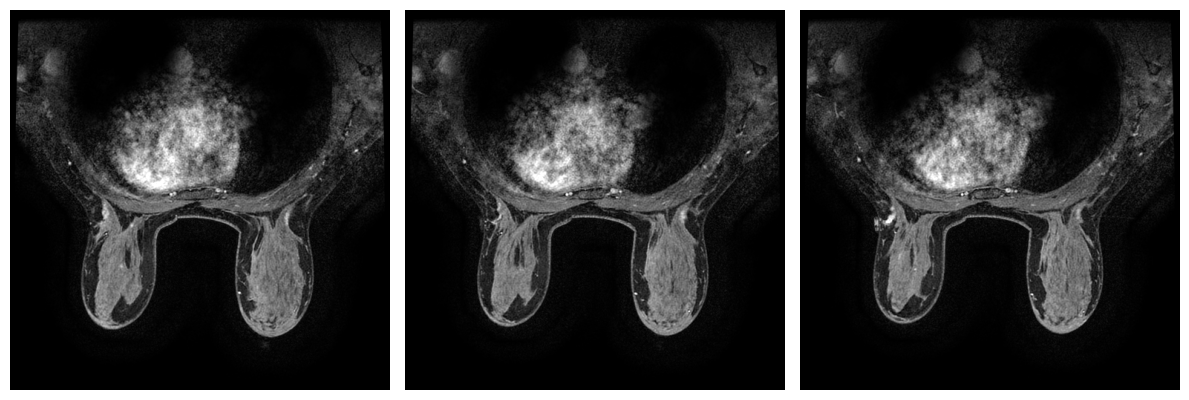

In [6]:
display_images(load_img)


# Filtiranje slika
Funckija *filtriranje* prima listu sa slikama i metod kao argument. U zavisnosti od izabranog metoda izvrsice filtriranje nad svima slikama. Moze se dodati jos metoda za filtraciju i na taj nacin ispitati i utvrditi koji je najbolji.

In [7]:
def filtriranje(images, method = 'non_loacl_means'):
  denoised_images = []

  for img in images:
    if method == 'non_local_means':
      denoised_img = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)
    elif method == 'gaussian':
      denoised_img = cv2.GaussianBlur(img, (5, 5), 0)
    elif method == 'median':
      denoised_img = cv2.medianBlur(img, 5)
    else:
      raise ValueError("Nepoznati metod za filtriranje")

    denoised_images.append(denoised_img)

  return denoised_images



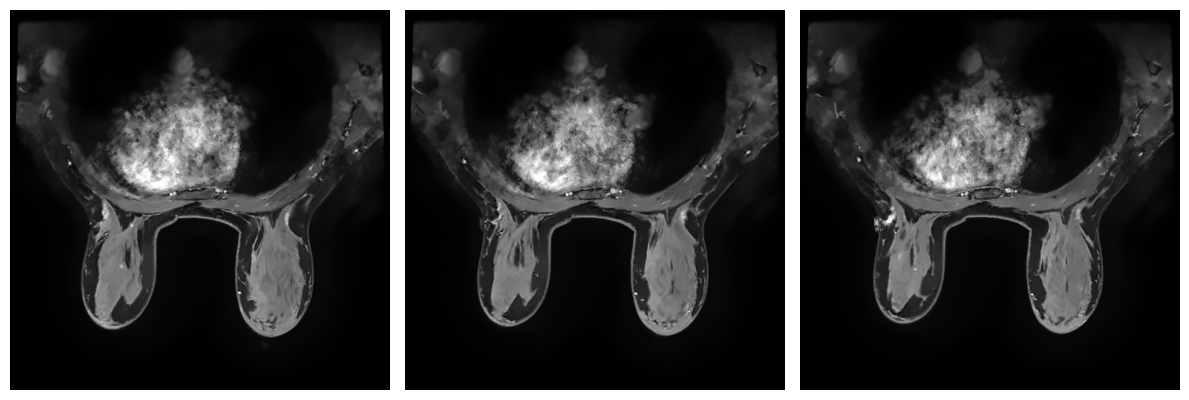

In [8]:
denoised_images = filtriranje(load_img, method='non_local_means')
display_images(denoised_images)


# Podesavanje kontrasta
Funkcija *podesavanje_kontrasta* prima listu, metod i podesive parametre kao argument. U zavisnosti od odabranog metoda moze se pristupiti pojedinacnogm parametru svake od funkcija i na taj nacin efikasnije da se vrsi isprobavanje razlicitih metoda. Na primer, ukoliko zelimo da promenimo clipLimit paramtar mozemo napisati:
**enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method, clip_limit = 1.5)**

In [9]:
def podesavanje_kontrasta(images, method = 'clahe', **kwargs):
  enhanced_images = []

  for img in images:
    if method == 'clahe':
      clip_limit = kwargs.get('clip_limit', 2.0)
      tile_grid_size = kwargs.get('tile_grid_size', (8,8))
      clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
      enhanced_img = clahe.apply(img)


    elif method == 'ahe':
      kernel_size = kwargs.get('kernel_size', (8,8))
      img_padded = np.pad(img, ((kernel_size[0]//2, kernel_size[0]//2),
                                (kernel_size[1]//2, kernel_size[1]//2)),
                          mode='reflect')
      enhanced_img = np.zeros_like(img)
      for i in range(img.shape[0]):
        for j in range(img.shape[1]):
          local_region = img_padded[i:i+kernel_size[0], j:j+kernel_size[1]]
          enhanced_img[i,j] = cv2.equalizeHist(local_region)[kernel_size[0]//2, kernel_size[1]//2]

    elif method == 'gamma':
      gamma = kwargs.get('gamma', 1.0)
      inv_gamma = 1.0 / gamma
      table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
      enhanced_img = cv2.LUT(img, table)

    elif method == 'unsharp':
      sigma = kwargs.get('sigma', 1.0)
      strength = kwargs.get('strength', 1.5)
      blurred_img = cv2.GaussianBlur(img, (0, 0), sigma)
      enhanced_img = cv2.addWeighted(img, 1+strength, blurred_img, -strength, 0)

    else:
      raise ValueError("Nepostojeci metod")

    enhanced_images.append(enhanced_img)

  return enhanced_images


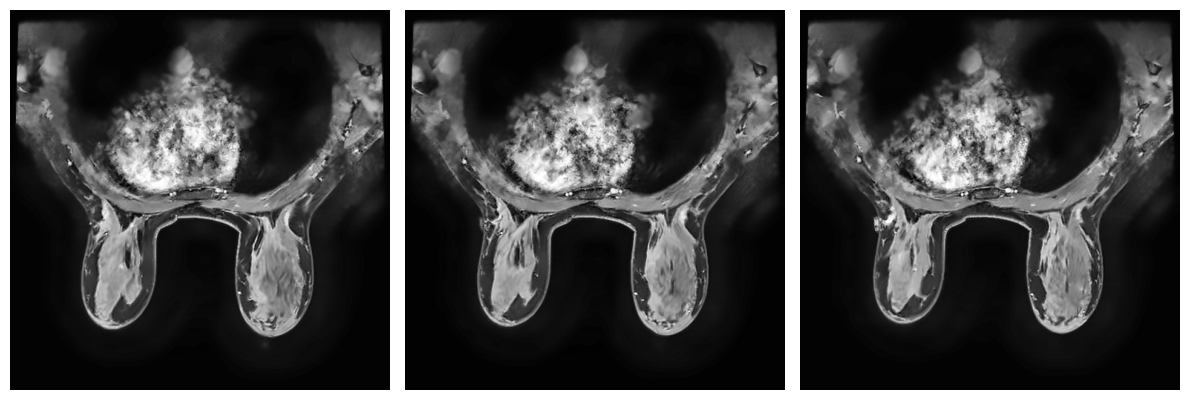

In [10]:
contrast_method = 'clahe'
enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method)
display_images(enhanced_images)

In [11]:
# nije pouzdana metoda
def detect_heart_based_on_intensity(images, threshold = 45):
  results = []
  for img in images:
    avg_intensity = np.mean(img)

    heart_present = avg_intensity > threshold
    results.append(heart_present)

  return results



In [12]:
#-----------Ideja------------------
# Odrediti oblast gde se ocekuje da se pojavi srce
# Koordinate se mogu manuelno dodeliti u zavisnosti od slike
# koordinate su vidljive ukoliko se iskoristi plotly.express za prikaz slika
# ovo je pozeljno da se odradi zbog slika sa razlicitim intenzitetom i sumom
# Analiza prosecnog intenziteta ili histograma samo u toj oblasti
# x = 80, y = 0, w = 320, h = 250

roi_box = [80, 0, 320, 250]

def detect_heart_based_on_roi(images, threshold = 45):
  global roi_box
  result = []
  avg_intensity_ = []
  roi_images = []
  num_images = len(images)

  fig, axes = plt.subplots(1, num_images, figsize = (15, 5))

  if num_images == 1:
    axes = [axes]

  for i, (img, ax) in enumerate(zip(images,axes)):

    ax.imshow(img, cmap='gray')

    x, y, w, h = roi_box
    rect = Rectangle((x, y), w, h, linewidth = 1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


    x, y, w, h = roi_box
    roi = img[y:y+h, x:x+w]
    avg_intensity = np.mean(roi)

    heart_visible = avg_intensity > threshold
    result.append(heart_visible)
    avg_intensity_.append(avg_intensity)
    roi_images.append(roi)

  plt.show()
  return result, avg_intensity_, roi_images



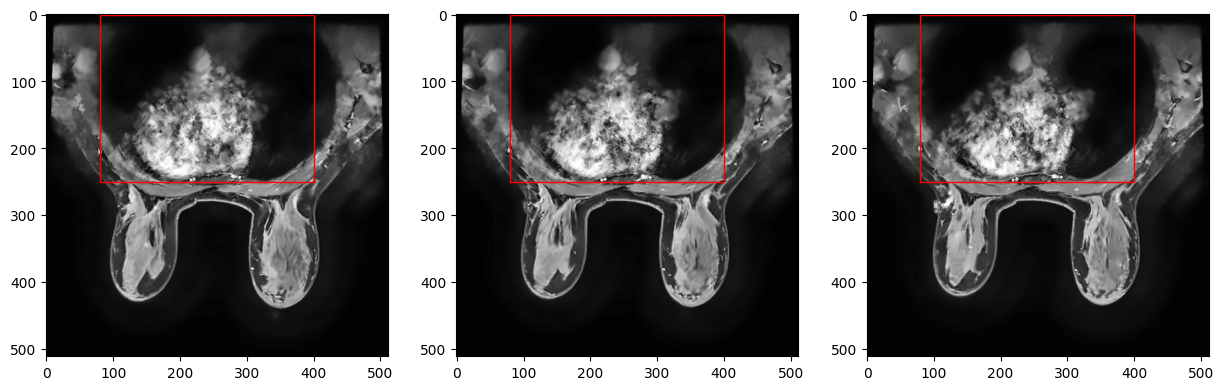

[62.2594875, 62.1721125, 61.9154625]
[True, True, True]


In [13]:
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)
print(avg_intensity)
print(results)


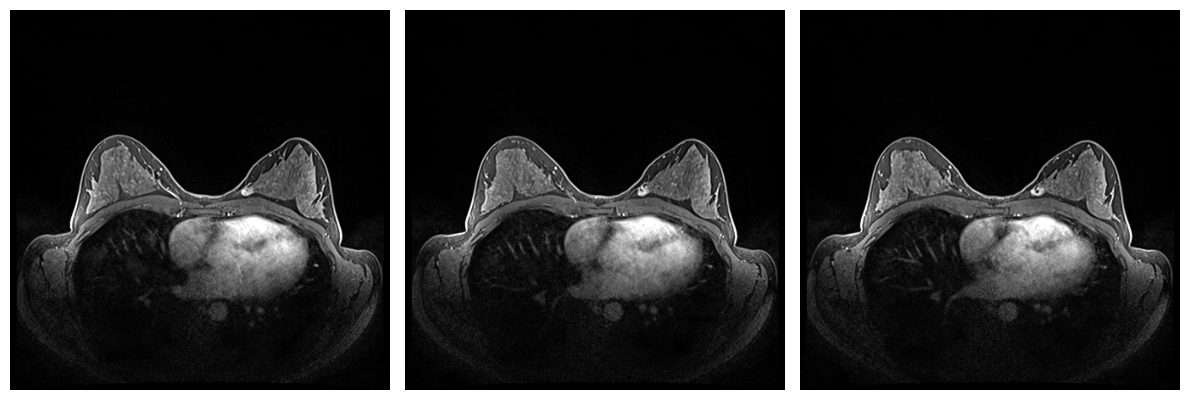

In [14]:
patient_id = '007'
load_img = get_patient_images(patient_images, patient_id)
display_images(load_img)

# Okretanje slika
Pruzanje korisniku da pomocu funkcije *flip_imgs* okrene slike kao bi se detektovao roi

In [15]:
def flip_imgs(patient_imgs):
  flip_imgs = []
  for img in patient_imgs:
    flip_img = cv2.flip(img, 0)

    flip_imgs.append(flip_img)

  return flip_imgs


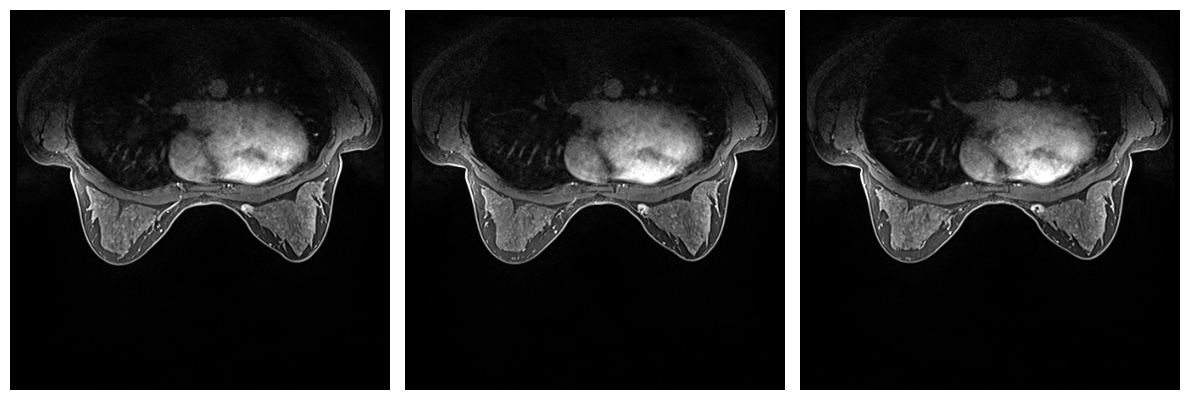

In [16]:
vertically_flip = flip_imgs(load_img)
display_images(vertically_flip)

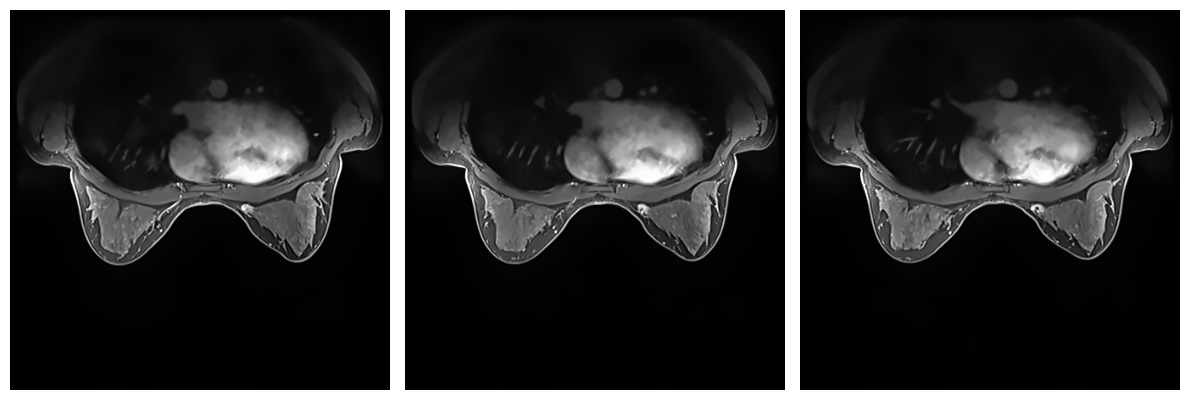

In [17]:
denoised_images = filtriranje(vertically_flip, method='non_local_means')
display_images(denoised_images)


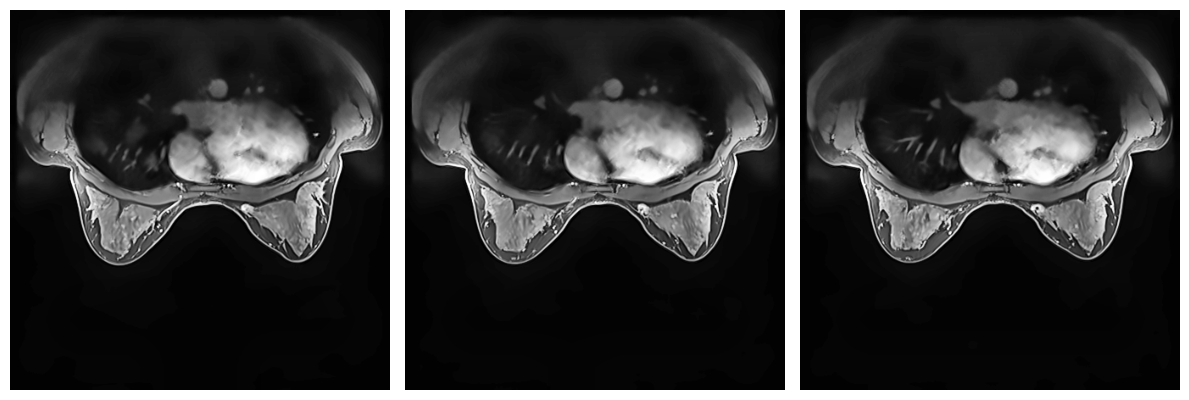

In [18]:
contrast_method = 'clahe'
enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method)
display_images(enhanced_images)

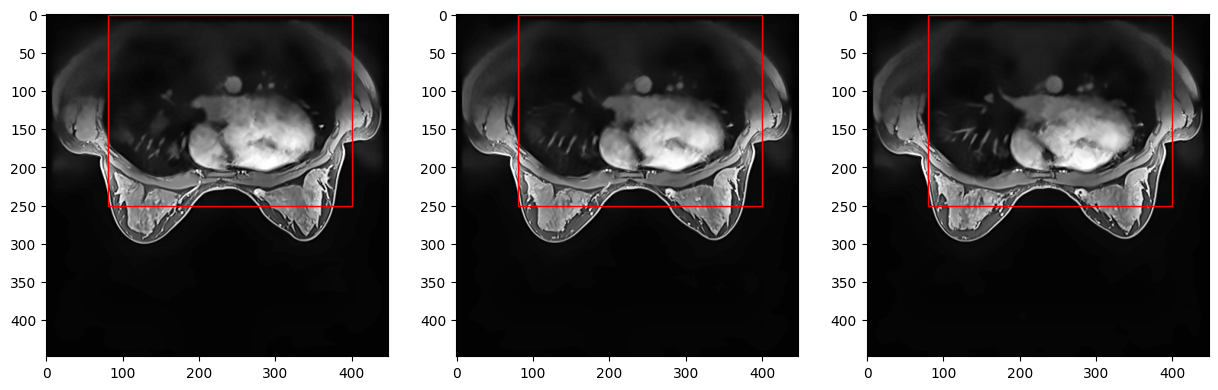

[64.0225, 63.307275, 62.86655]
[True, True, True]


In [19]:
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)
print(avg_intensity)
print(results)

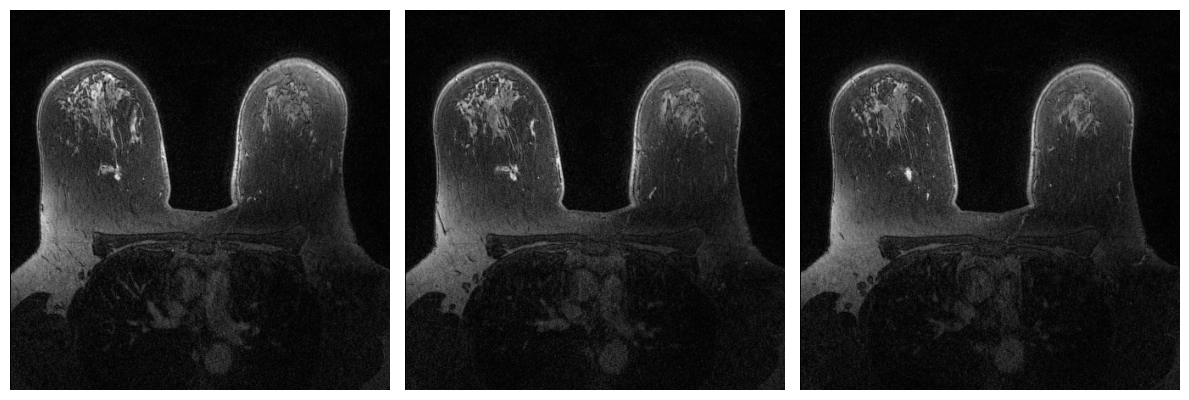

In [20]:
patient_id = '008'
load_img = get_patient_images(patient_images, patient_id)
display_images(load_img)

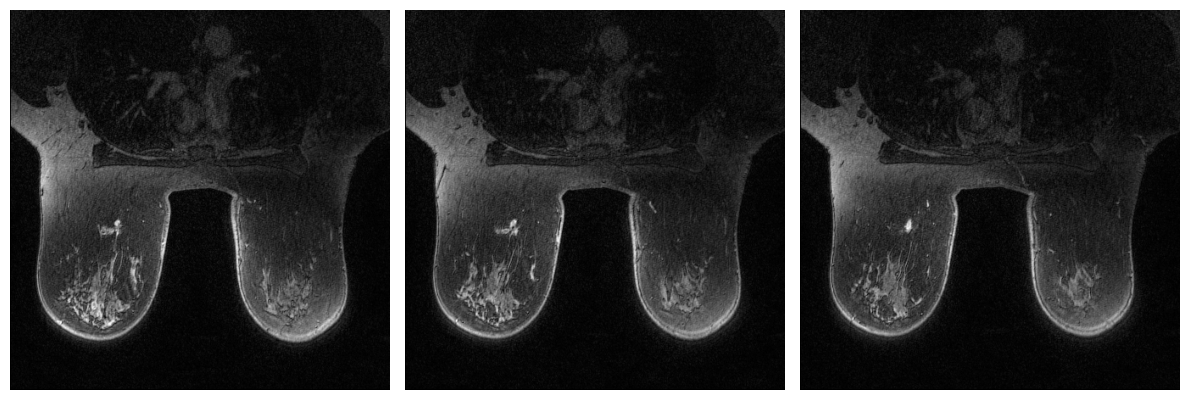

In [21]:
vertically_flip = flip_imgs(load_img)
display_images(vertically_flip)

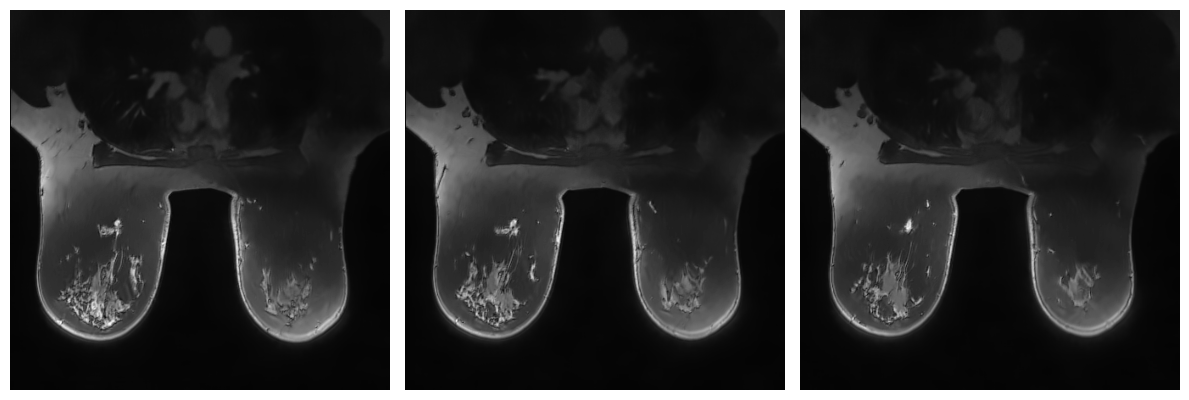

In [22]:
denoised_images = filtriranje(vertically_flip, method='non_local_means')
display_images(denoised_images)

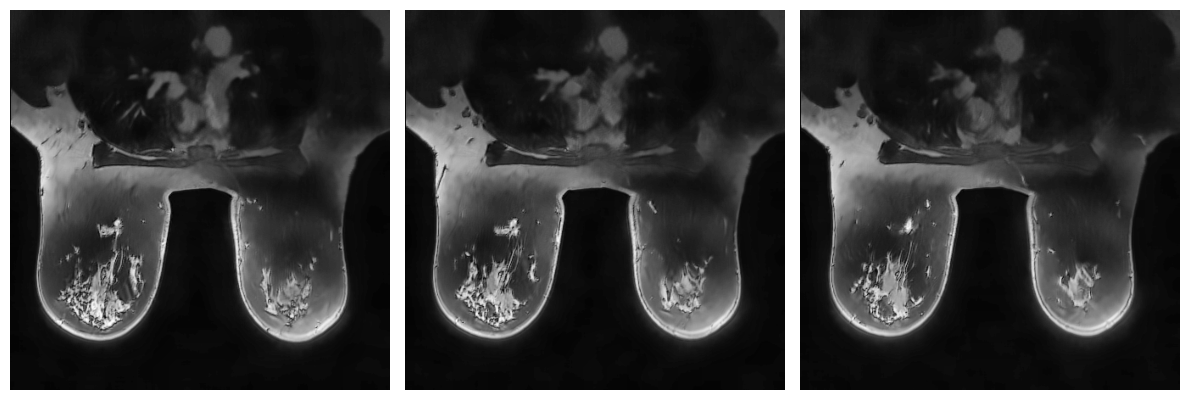

In [23]:
contrast_method = 'clahe'
enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method)
display_images(enhanced_images)

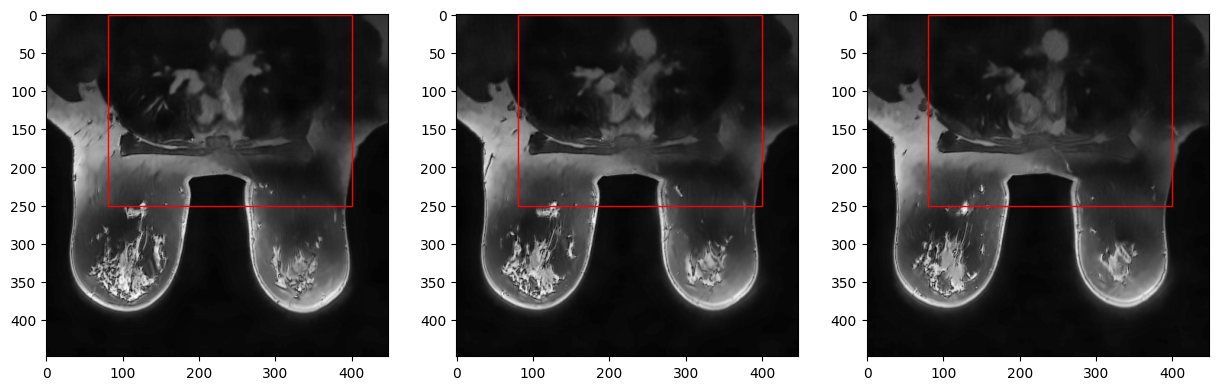

[41.0715625, 40.1429375, 38.9944125]
[False, False, False]


In [24]:
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)
print(avg_intensity)
print(results)

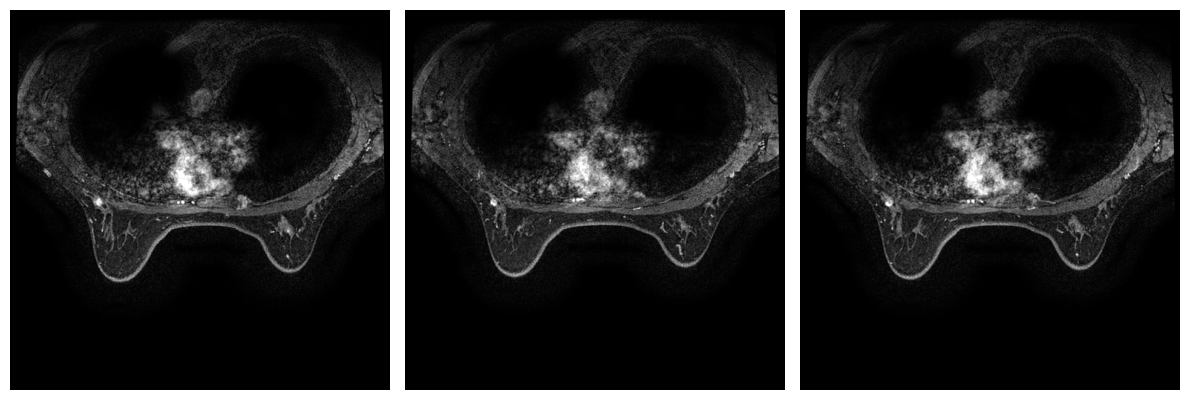

In [25]:
patient_id = '111'
load_img = get_patient_images(patient_images, patient_id)
display_images(load_img)

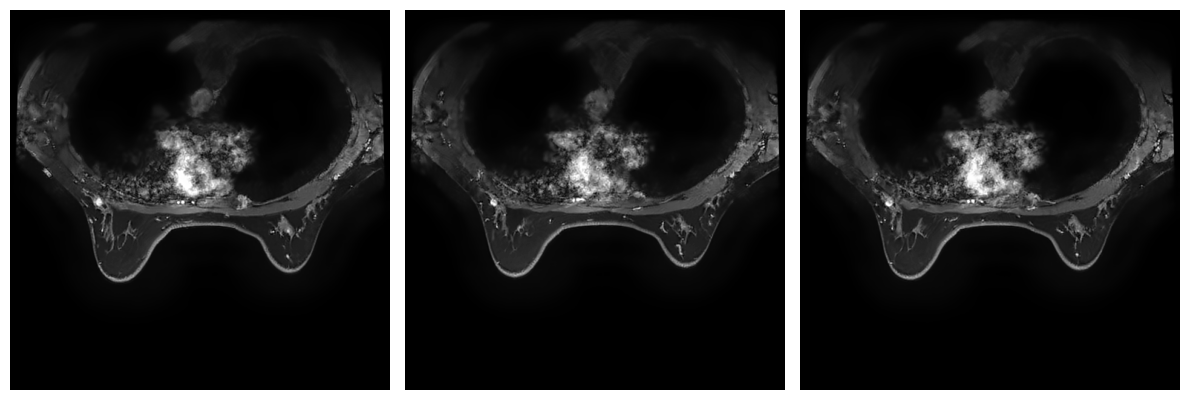

In [26]:
denoised_images = filtriranje(load_img, method='non_local_means')
display_images(denoised_images)

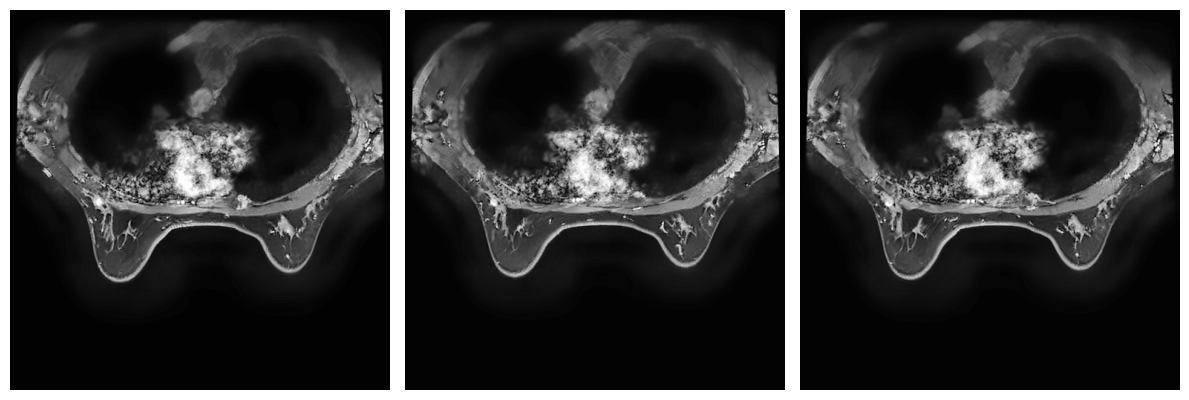

In [27]:
contrast_method = 'clahe'
enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method)
display_images(enhanced_images)

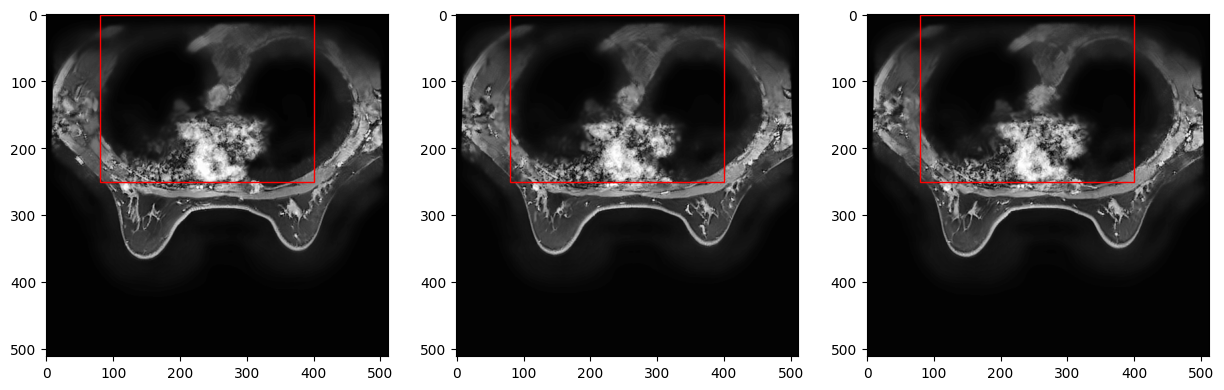

[46.3352, 45.787725, 46.220125]
[True, True, True]


In [28]:
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)
print(avg_intensity)
print(results)

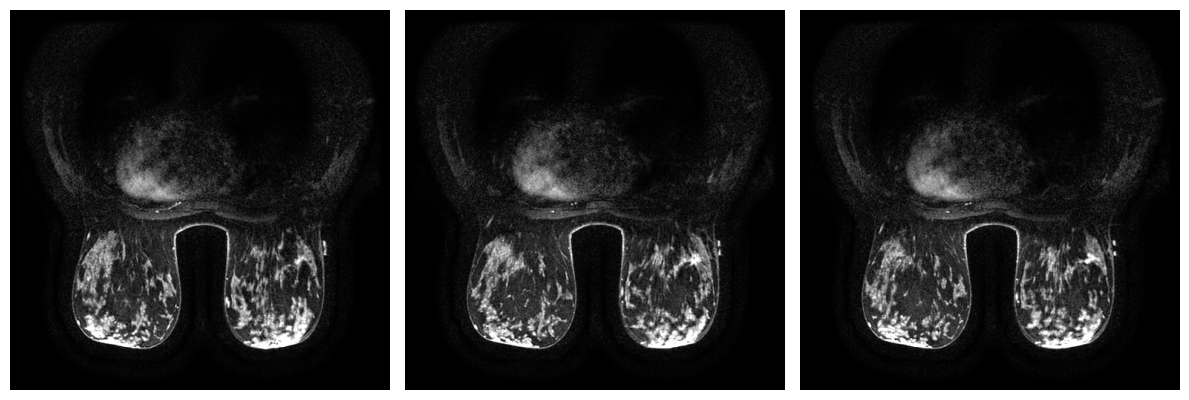

In [29]:
patient_id = '118'
load_img = get_patient_images(patient_images, patient_id)
display_images(load_img)

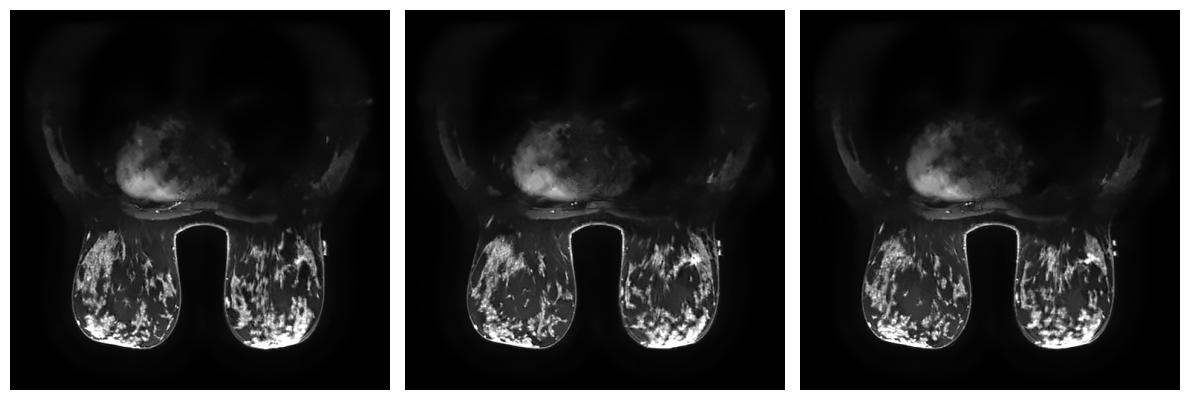

In [30]:
denoised_images = filtriranje(load_img, method='non_local_means')
display_images(denoised_images)

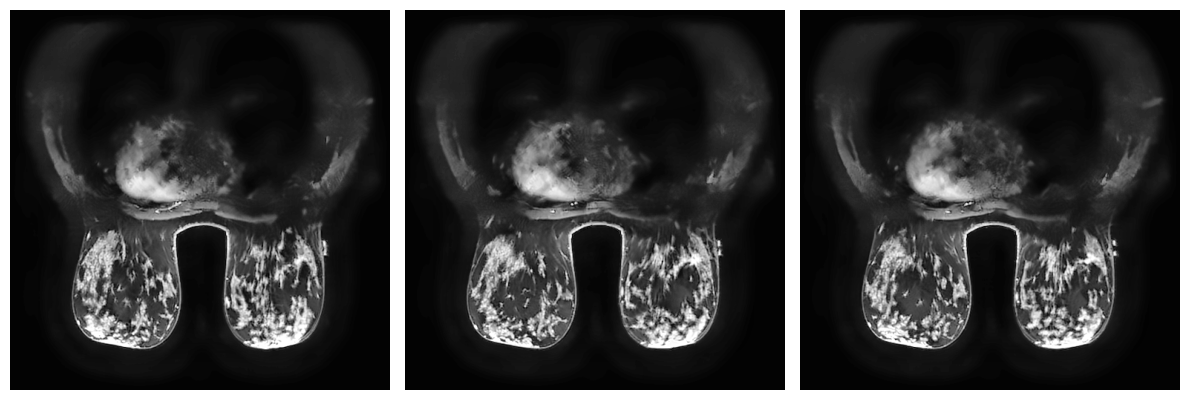

In [31]:
contrast_method = 'clahe'
enhanced_images = podesavanje_kontrasta(denoised_images, method = contrast_method)
display_images(enhanced_images)

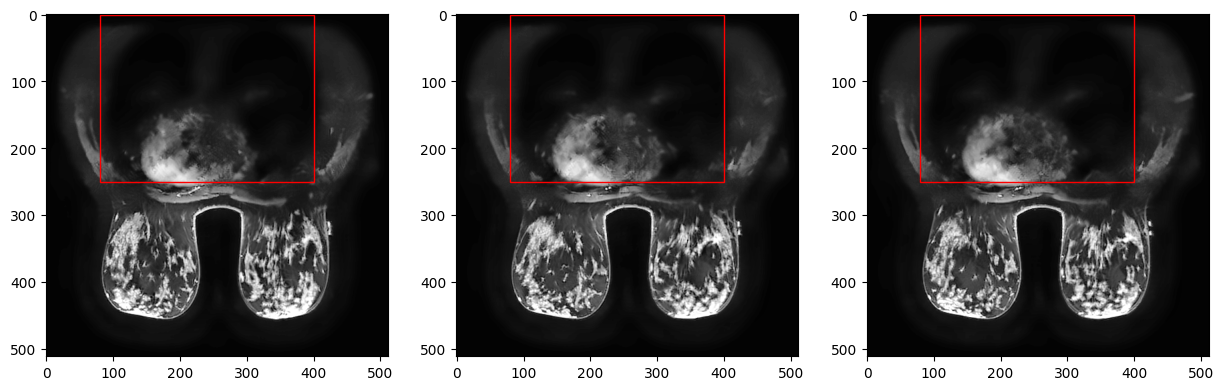

[27.833175, 29.3967375, 28.6202]
[False, False, False]


In [32]:
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)
print(avg_intensity)
print(results)

In [33]:
def apply_thresholding(images):
  thresh_images = []

  for img in images:

    _, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh_images.append(thresh_img)

  return thresh_images

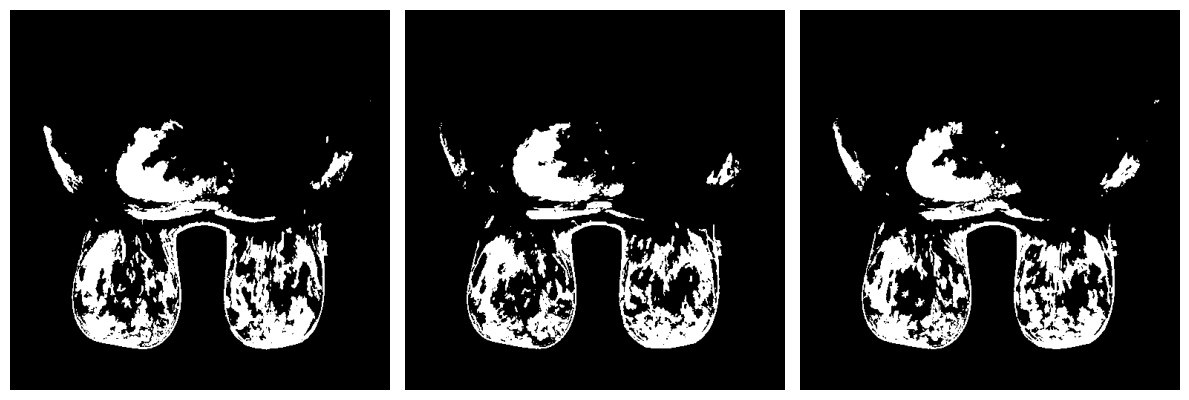

In [34]:
thresh_images = apply_thresholding(enhanced_images)
display_images(thresh_images)

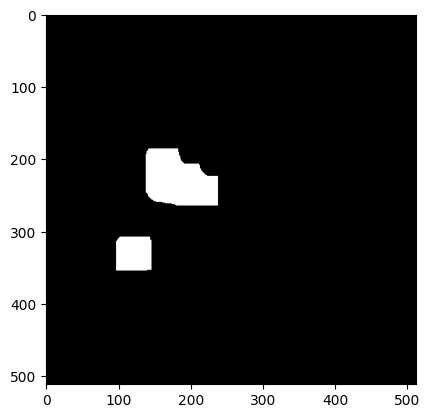

In [35]:
thresh = thresh_images[0]
img = enhanced_images[0].astype('uint8')

kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = cv2.dilate(sure_fg, np.ones((9, 9), np.uint8), iterations=5)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(sure_fg, cmap='gray')
plt.show()


In [36]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

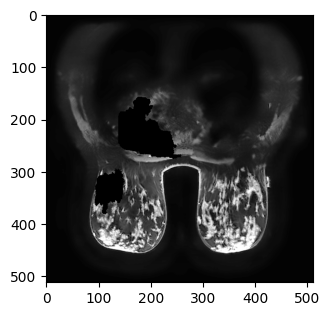

In [37]:
if len(img.shape) == 2:  # If the image is grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

img[markers == -1] = [0,0,0]

for marker in np.unique(markers):
    if marker == -1 or marker == 1:
        continue
    img[markers == marker] = [0, 0, 0]

plt.figure(figsize=(20,20))
plt.subplot(151)
plt.imshow(img, cmap='gray')
plt.show()

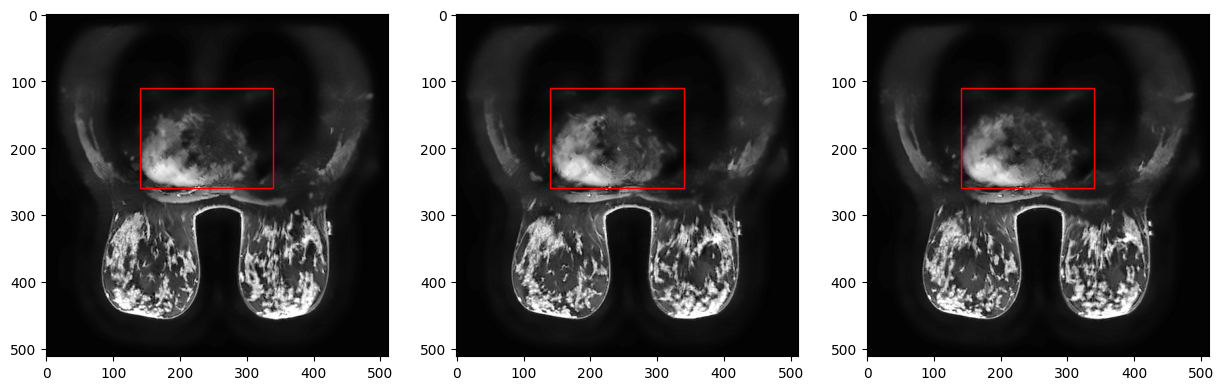

[57.10456666666666, 60.039033333333336, 58.609233333333336]
[True, True, True]


In [38]:
# globalna promenljiva roi_box
roi_box = [140, 110, 200, 150]
results, avg_intensity, roi = detect_heart_based_on_roi(enhanced_images)

print(avg_intensity)
print(results)

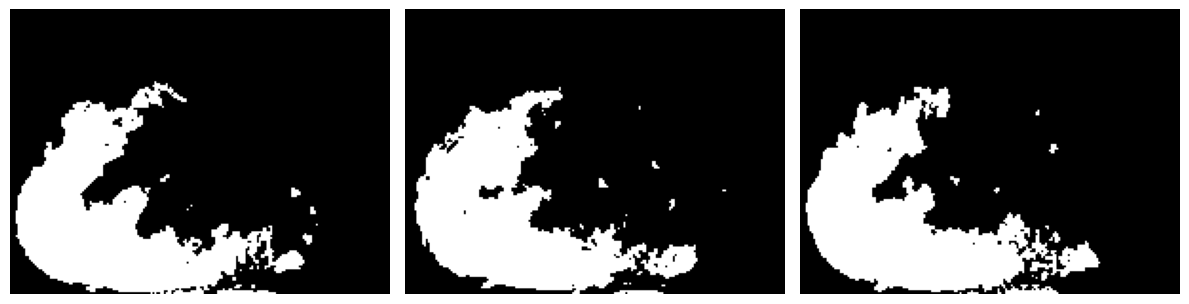

In [39]:
thresh_roi = apply_thresholding(roi)
display_images(thresh_roi)


In [139]:
def apply_watershed(images, roi_images, roi_box):

  enhanced_images = podesavanje_kontrasta(roi_images, 'gamma', gamma = 2.5)
  masks = []
  markers_ = []
  roi_ = []
  kernel = np.ones((5, 5), np.uint8)
  x, y, w, h = roi_box

  for img, roi in zip(images, enhanced_images):

    _, thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 1)

    sure_bg = cv2.dilate(opening, kernel, iterations = 2)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    sure_fg = cv2.dilate(np.uint8(sure_fg), np.ones((9,9), np.uint8), iterations = 3)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(np.uint8(sure_fg))
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = np.int32(markers)

    if len(roi.shape) == 2:
        roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)

    markers = cv2.watershed(roi, markers)

    mask = np.zeros_like(roi, dtype = np.uint8)
    mask[markers != 1] = [255, 255, 255]

    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    mask_resized = np.zeros_like(img, dtype = np.uint8)
    mask_resized[y:y+h, x:x+w] = mask_gray

    masked_img = img.copy()
    masked_img[mask_resized == 255] = 0

    masks.append(masked_img)

  return masks

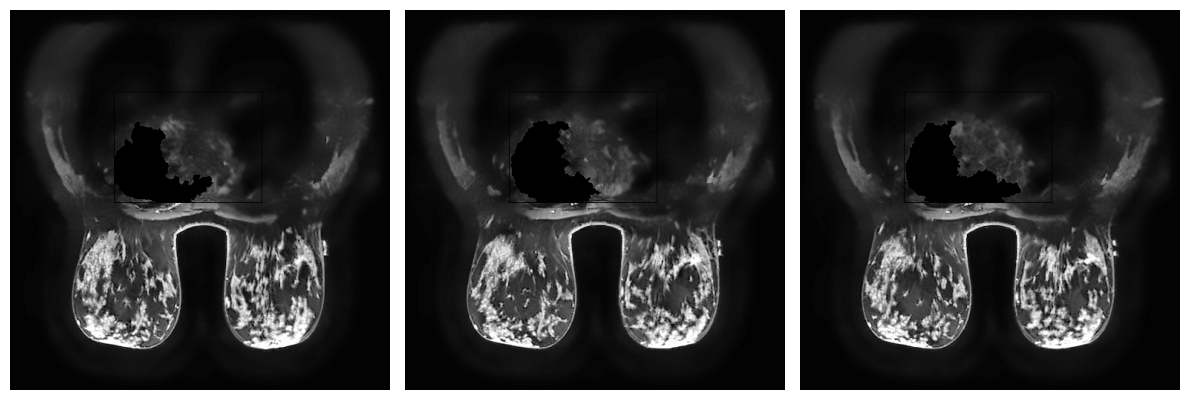

In [140]:
masked_images = apply_watershed(enhanced_images, roi, roi_box)
display_images(masked_images)